In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import math
from byol_pytorch import BYOL


os.environ['KMP_DUPLICATE_LIB_OK']='True'

: 

In [ ]:
class P2_pretrain_Dataset(Dataset):
    def __init__(self, root, transform=None):
        """ Intialize the dataset """
        self.images = None
        self.root = root
        self.transform = transform

        

        # read filenames
        self.imagenames = [file for file in os.listdir(root)]
        
        self.len = len(self.imagenames)
                              
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        #image_id = self.annotations[index]["image_id"]
        #caption = self.annotations[index]["caption"]
        #image_fn = [x["file_name"] for x in self.images if x["id"] == image_id]
        fn = self.imagenames[index]
        image = Image.open(os.path.join(self.root, fn))
        image = image.convert('RGB')
        
        
        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        """ Total number of samples in the dataset """
        return self.len

# captions in trainset: 38400
Device used: cuda
Image tensor in each batch: torch.Size([64, 3, 128, 128]) torch.float32


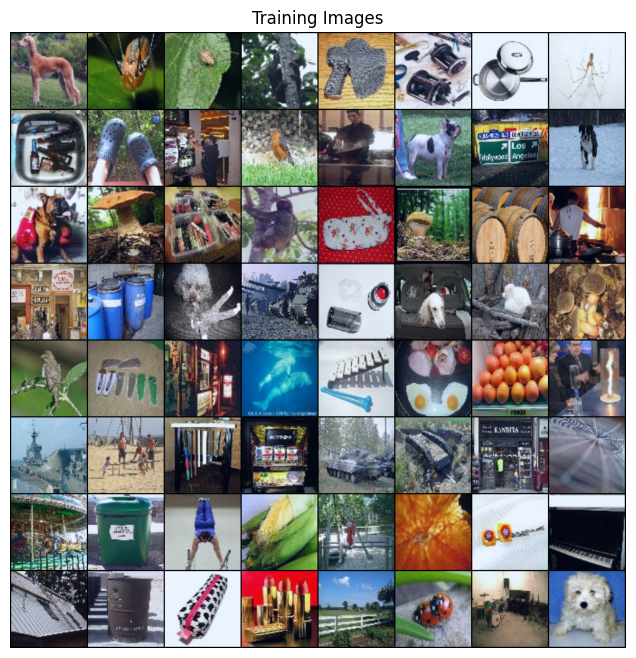

In [ ]:
transformforP2pre = transforms.Compose([
  transforms.Resize((128,128)),
  transforms.CenterCrop(128),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = P2_pretrain_Dataset(root="hw4_data/mini/train/", transform=transformforP2pre)

print('# captions in trainset:', len(trainset)) 


# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print('Device used:', device)

dataiter = iter(trainset_loader)
images = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
#print('Label tensor in each batch:', fn.shape, fn.dtype)
#print(fn)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images.to(device)[0:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer = None):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    if optimizer!=None:
        optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
def train(model, optimizer, epoch, log_interval=100):
    criterion = nn.BCELoss()
    iteration = 0
    
    for ep in range(epoch):
        allloss = 0
        model.train()
        
        for batch_idx, data in enumerate(trainset_loader):
            image = data.to(device)
            loss = model(image)
            allloss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.update_moving_average() # update moving average of target encoder
            
            if iteration % log_interval == 0:
                print('Train Epoch: [{}/{}] [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                        ep+1, epoch, batch_idx * len(data), len(trainset_loader.dataset),
                        100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        print('Epoch: [{}/{}]\t Total Loss: {:.6f}\t'.format(
                        ep+1, epoch, allloss))
        if ep % 10 == 9:
            save_checkpoint('P2model/resnet50-%i.pth' % ep, model, optimizer)

In [ ]:
backbone = models.resnet50(pretrained=False)
model = BYOL(
    backbone,
    image_size = 128,
    hidden_layer = 'avgpool'
).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

c:\Users\W\anaconda3\envs\hw3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\W\anaconda3\envs\hw3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train(model, optimizer, 100)

Train Epoch: [1/100] [0/38400 (0%)]	 Loss: 3.913371


KeyboardInterrupt: 